Random Forest
Rough steps:
- load the split csv files
- build the preprocesing part
- train a basic random forest
- train an improved version by balancing class weight
- tune the number of trees
- tune the number of features 

In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

In [2]:
#Loading train test val splits and getting the numeric and categorical columns
X_train = pd.read_csv("../data/X_train.csv")
X_val   = pd.read_csv("../data/X_val.csv")
X_test  = pd.read_csv("../data/X_test.csv")

y_train = pd.read_csv("../data/y_train.csv").squeeze()
y_val   = pd.read_csv("../data/y_val.csv").squeeze()
y_test  = pd.read_csv("../data/y_test.csv").squeeze()


numeric_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=["number"]).columns.tolist()

#Moving FLAG_MOBIL into a categorical column since its just a flag and not technically a numeric column
if "FLAG_MOBIL" in numeric_cols:
    numeric_cols.remove("FLAG_MOBIL")
    categorical_cols.append("FLAG_MOBIL")

print("Numeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)

Numeric cols: ['AMT_INCOME_TOTAL', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'CNT_FAM_MEMBERS']
Categorical cols: ['OCCUPATION_TYPE', 'CODE_GENDER', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_MOBIL']


In [3]:
#Filling any missing numeric values with the median
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

#Filling missing categories with "Mising"
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

#Transforming the columns so they're usable
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ],
    remainder="drop"
)

In [4]:
#Our helper to evaluate a model and print its metrics consistently for each model
def evaluate(model, X, y, label=""):
    preds = model.predict(X)
    
    acc = accuracy_score(y, preds) #overall correct %
    prec = precision_score(y, preds, zero_division=0) #where it predicts 1, how many were actually 1
    rec = recall_score(y, preds, zero_division=0) # of the real 1s, how many were caught
    f1 = f1_score(y, preds, zero_division=0) #some averagte of precision and recall (important one)

    print("\n", label, "")
    print("accuracy:", round(acc,4))
    print("precision:", round(prec, 4), " recall:", round(rec, 4), " f1:", round(f1, 4))
    print("confusion matrix:\n", confusion_matrix(y, preds))

    print(classification_report(y, preds, zero_division=0)) #detailed - use this in report

    return{"acc": acc, "prec": prec, "rec": rec, "f1": f1}

In [5]:
#The first random forest, training the most basic version with not balanced weight class
rf_v1 = Pipeline(steps=[
    ("preproc", preprocessor), #preprocessing
    ("clf", RandomForestClassifier(
        n_estimators=300, #no. trees
        random_state=42,
        n_jobs=-1
    ))
])

rf_v1.fit(X_train, y_train) #train model on training data

val_v1 = evaluate(rf_v1, X_val, y_val, "RF v1 (valdiation") 
test_v1 = evaluate(rf_v1, X_test, y_test, "RF v1 (test)")


 RF v1 (valdiation 
accuracy: 0.9879
precision: 0.3333  recall: 0.1379  f1: 0.1951
confusion matrix:
 [[5395   16]
 [  50    8]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5411
           1       0.33      0.14      0.20        58

    accuracy                           0.99      5469
   macro avg       0.66      0.57      0.59      5469
weighted avg       0.98      0.99      0.99      5469


 RF v1 (test) 
accuracy: 0.9898
precision: 0.5185  recall: 0.2456  f1: 0.3333
confusion matrix:
 [[5399   13]
 [  43   14]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5412
           1       0.52      0.25      0.33        57

    accuracy                           0.99      5469
   macro avg       0.76      0.62      0.66      5469
weighted avg       0.99      0.99      0.99      5469



In [6]:
#Second iteration, I'm trying to handle the class imbalance 
rf_v2 = Pipeline(steps=[
    ("preproc", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced" #balancing to help high_risk = 1
    ))
])

rf_v2.fit(X_train, y_train) #training model on training data

val_v2 = evaluate(rf_v2, X_val, y_val, "RF v2 balanced (validation)")
test_v2 = evaluate(rf_v2, X_test, y_test, "RF v2 balanced (test)")


 RF v2 balanced (validation) 
accuracy: 0.9792
precision: 0.22  recall: 0.3793  f1: 0.2785
confusion matrix:
 [[5333   78]
 [  36   22]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5411
           1       0.22      0.38      0.28        58

    accuracy                           0.98      5469
   macro avg       0.61      0.68      0.63      5469
weighted avg       0.99      0.98      0.98      5469


 RF v2 balanced (test) 
accuracy: 0.9779
precision: 0.2091  recall: 0.4035  f1: 0.2754
confusion matrix:
 [[5325   87]
 [  34   23]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      5412
           1       0.21      0.40      0.28        57

    accuracy                           0.98      5469
   macro avg       0.60      0.69      0.63      5469
weighted avg       0.99      0.98      0.98      5469



In [7]:
final_model = rf_v2

# get feature names after preprocessing
preproc = final_model.named_steps["preproc"]
feature_names = preproc.get_feature_names_out()

# get RF importances
rf = final_model.named_steps["clf"]
importances = rf.feature_importances_

# build table
fi = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

# show top 10
fi.head(10)

,feature,importance
2,num__DAYS_BIRTH,0.252121
1,num__DAYS_EMPLOYED,0.184795
0,num__AMT_INCOME_TOTAL,0.183290
3,num__CNT_FAM_MEMBERS,0.057539
16,cat__OCCUPATION_TYPE_Missing,0.020981
29,cat__NAME_EDUCATION_TYPE_Secondary / secondary...,0.019263
24,cat__CODE_GENDER_M,0.018397
23,cat__CODE_GENDER_F,0.017843
31,cat__NAME_FAMILY_STATUS_Married,0.017326
33,cat__NAME_FAMILY_STATUS_Single / not married,0.016755


,n_estimators,val_f1,val_precision,val_recall
0,10,0.295775,0.250000,0.362069
1,25,0.270270,0.222222,0.344828
2,50,0.278481,0.220000,0.379310
3,60,0.282051,0.224490,0.379310
4,70,0.272727,0.218750,0.362069
5,85,0.274510,0.221053,0.362069
6,100,0.274510,0.221053,0.362069
7,120,0.274510,0.221053,0.362069
8,150,0.278481,0.220000,0.379310
9,175,0.278481,0.220000,0.379310


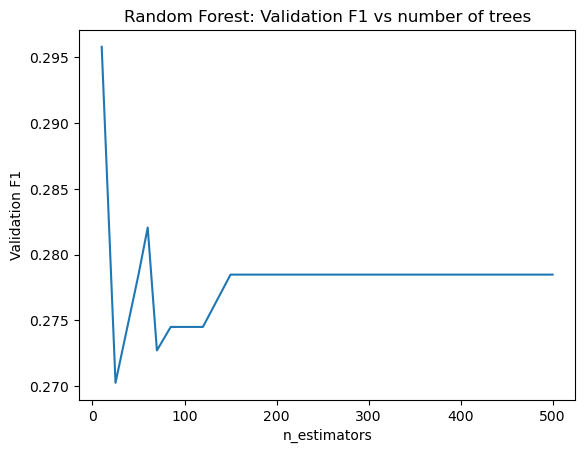

In [8]:
#Now by tuning the number of trees, will this improve F1?
trees_list = [10, 25, 50, 60, 70, 85, 100, 120, 150, 175, 200, 225, 250, 275, 300, 500] #trying on these values
results = [] #storing the results in here

for n in trees_list:
    model = Pipeline(steps=[
        ("preproc", preprocessor),
        ("clf", RandomForestClassifier(
            n_estimators=n, #trying diff number of trees
            random_state=42,
            n_jobs=-1,
            class_weight="balanced"
        ))
    ])
    model.fit(X_train, y_train)
    pred_val = model.predict(X_val) #predicting on the validation split

    #storing the results here
    results.append({
        "n_estimators": n,
        "val_f1": f1_score(y_val, pred_val, zero_division=0),
        "val_precision": precision_score(y_val, pred_val, zero_division=0),
        "val_recall": recall_score(y_val, pred_val, zero_division=0),
    })

#turning the list into a table to see better 
df_trees = pd.DataFrame(results)
display(df_trees)

#Make a plot to see if f1 improves with more trees, or plateaus
plt.plot(df_trees["n_estimators"], df_trees["val_f1"])
plt.xlabel("n_estimators")
plt.ylabel("Validation F1")
plt.title("Random Forest: Validation F1 vs number of trees")
plt.show()
#graph does show a plateau at around 200, so we use a number from around 200 rather than something like 10 as its more stable

In [ ]:
#Trying to tune max_features to see if it performs better
max_features_list = ["sqrt", "log2", 0.3, 0.5, None]
rows = []

for mf in max_features_list:
    model = Pipeline(steps=[
        ("prep", preprocessor),#preprocess
        ("rf", RandomForestClassifier(
            n_estimators=300,
            random_state=42,
            n_jobs=-1,
            class_weight="balanced",
            max_features=mf
        ))
    ])
    model.fit(X_train, y_train)#train
    preds = model.predict(X_val)#predicting on val split

    #same as before where we store our results here
    rows.append({
        "max_features": mf,
        "val_f1": f1_score(y_val, preds, zero_division=0),
        "val_precision": precision_score(y_val, preds, zero_division=0),
        "val_recall": recall_score(y_val, preds, zero_division=0),
        "val_pred_pos": int((preds == 1).sum())
    })

#turning the stored results into a table to view better 
mf_results = pd.DataFrame(rows)
display(mf_results)

best_mf = mf_results.iloc[0]["max_features"]
print("best max_features (f1):", best_mf)


In [ ]:
X_train_full = pd.concat([X_train, X_val], axis=0)
y_train_full = pd.concat([y_train, y_val], axis=0)

rf_v3 = Pipeline(steps=[
    ("prep", preprocessor),
    ("rf", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced",
        max_features=best_mf
    ))
])

rf_v3.fit(X_train_full, y_train_full)
test_v3 = evaluate(rf_v3, X_test, y_test, f"RF v3 tuned (test) max_features={best_mf}")


In [ ]:
summary = pd.DataFrame([
    {"model": "RF v1", "val_f1": val_v1["f1"], "test_f1": test_v1["f1"]},
    {"model": "RF v2 (balanced)", "val_f1": val_v2["f1"], "test_f1": test_v2["f1"]},
    {"model": "RF v3 (tuned max_features)", "val_f1": np.nan, "test_f1": test_v3["f1"]},
])
summary


Conclusion:

So with RF v1 (has no class weights) it has the best overall balance, but it predicted relatively few positives which is why the FP number is so low

RF v2 (has class_weight="balanced") increased recall meaning it found more true high risk cases, but false positives also increased meaning the F1 score was slightly lower

Tuning the number of trees showed a plateau after about 200 trees, so i kept it at 300 trees for stability and shorter run time

Tuning the maax_features showed to be fairly similar results to RF v2

Overall, the The Random forest models give better F1 scores for the high_risk = 1 cases than the SVM did.